# SSP-MMC for FSRS

SSP-MMC stands for "Stochastic-Shortest-Path-Minimize-Memorization-Cost". It is a reinforcement learning algorithm that is designed to minimize the cost of memorization in the context of spaced repetition. This is a re-implementation of the original SSP-MMC algorithm in Numpy. The memory model is updated to FSRS instead of DHP-HLR.

Original code: https://github.com/maimemo/SSP-MMC

## He uses Retrievability R in the stability_after_success/failure functions. I think I have to understand this as a function of the current time/ the time since the last review and Stability

but why does he take the min over the retrievability dimension then? 
because the algorithm can choose at which time (-> at which R) to schedule the next review!

okay so how do I translate this into an urgency score?
- cost increases in the future -> urgency should be high
- cost decreases in the future -> urgency should be low



In [1]:
def format_time(minutes):
    if minutes < 60:
        return f"{minutes:.2f} min"
    elif minutes < 1440:  # Less than a day
        hours = minutes / 60
        return f"{hours:.2f} h"
    else:  # A day or more
        days = minutes / 1440
        return f"{days:.2f} d"

In [2]:
## Use the exponential part to encode the last review time (bachwards wrt. the session start) and the linear part to encode reviews within the session (forward )
## stability might neeed to have two exponential parts (one for the past and one for the distant future), and a linear part for the duration of the session

n_buckets = 64
n_linear = 32
min_duration = .5 # mins

exponent_candidates = [1.2, 1.5, 2]

for exponent in exponent_candidates:
    durations = [min_duration] * n_linear
    
    n_exponential = n_buckets - n_linear
    current_duration = min_duration
    for _ in range(n_exponential):
        current_duration *= exponent
        durations.append(current_duration)
        
    total_mins = sum(durations)
    print('\n\nTotal:', format_time(total_mins))
    print(f'Starting with last linear bucket (previously: {n_linear-1} * {min_duration:.2f}min):')
    for i in range(len(durations))[n_linear-1::3]:
        d = durations[i]
        cd = sum(durations[:i]) # cum before this
        print(i, '\t', format_time(cd), '\t', format_time(d))



Total: 17.31 h
Starting with last linear bucket (previously: 31 * 0.50min):
31 	 15.50 min 	 0.50 min
34 	 17.32 min 	 0.86 min
37 	 20.46 min 	 1.49 min
40 	 25.90 min 	 2.58 min
43 	 35.29 min 	 4.46 min
46 	 51.52 min 	 7.70 min
49 	 1.33 h 	 13.31 min
52 	 2.13 h 	 23.00 min
55 	 3.53 h 	 39.75 min
58 	 5.94 h 	 1.14 h
61 	 10.11 h 	 1.98 h


Total: 449.43 d
Starting with last linear bucket (previously: 31 * 0.50min):
31 	 15.50 min 	 0.50 min
34 	 17.88 min 	 1.69 min
37 	 25.89 min 	 5.70 min
40 	 52.94 min 	 19.22 min
43 	 2.40 h 	 1.08 h
46 	 7.54 h 	 3.65 h
49 	 1.04 d 	 12.32 h
52 	 3.47 d 	 1.73 d
55 	 11.70 d 	 5.85 d
58 	 39.47 d 	 19.73 d
61 	 133.17 d 	 66.58 d


Total: 2982616.19 d
Starting with last linear bucket (previously: 31 * 0.50min):
31 	 15.50 min 	 0.50 min
34 	 19.00 min 	 4.00 min
37 	 47.00 min 	 32.00 min
40 	 4.52 h 	 4.27 h
43 	 1.43 d 	 1.42 d
46 	 11.39 d 	 11.38 d
49 	 91.03 d 	 91.02 d
52 	 728.19 d 	 728.18 d
55 	 5825.43 d 	 5825.42 d
58 	 46603.

In [21]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

plt.style.use('ggplot')

again_cost = 25
hard_cost = 14
good_cost = 10
easy_cost = 6
first_rating_prob = np.array([0.15, 0.2, 0.6, 0.05])
review_rating_prob = np.array([0.3, 0.6, 0.1])

s_min = 0.1
s_max = 365
s_eps = 0.4
s_size = np.ceil((s_max - s_min) / s_eps + 1).astype(int)

d_min = 1
d_max = 10
d_eps = 0.3
d_size = np.ceil((d_max - d_min) / d_eps + 1).astype(int)

r_min = 0.69
r_max = 0.96
r_eps = 0.03
r_size = np.ceil((r_max - r_min) / r_eps + 1).astype(int)

DECAY = -0.5
FACTOR = 0.9 ** (1.0 / DECAY) - 1.0


def power_forgetting_curve(t, s): # takes in the time since last review and the stability, returns the retrievability
    return (1 + FACTOR * t / s) ** DECAY


def next_interval(s, r): # takes in stability and (desired) retrievability, returns the interval at which this is achieved
    ivl = s / FACTOR * (r ** (1.0 / DECAY) - 1.0)
    return np.maximum(1, np.floor(ivl))


cost_matrix = np.zeros((d_size, s_size))
cost_matrix.fill(1000)
cost_matrix[:, -1] = 0
action_matrix = np.zeros((d_size, s_size))

w = [
    0.5701, 1.4436, 4.1386, 10.9355,
    5.1443, 1.2006, 0.8627, 0.0362,
    1.629, 0.1342, 1.0166,
    2.1174, 0.0839, 0.3204, 1.4676,
    0.219, 2.8237
]


def stability_after_success(s, d, r, g):
    return s * (
        1
        + np.exp(w[8])
        * (11 - d)
        * np.power(s, -w[9])
        * (np.exp((1 - r) * w[10]) - 1)
        * (w[15] if g == 2 else 1)
        * (w[16] if g == 4 else 1)
    )


def stability_after_failure(s, d, r):
    return np.minimum(
        w[11]
        * np.power(d, -w[12])
        * (np.power(s + 1, w[13]) - 1)
        * np.exp((1 - r) * w[14]),
        s,
    )


def mean_reversion(init, current):
    return (w[7] * init + (1 - w[7]) * current).clip(1, 10)


def next_difficulty(d, g):
    return mean_reversion(w[4], d - w[6] * (g - 3))


# stability to index
def s2i(s): return np.clip(np.floor((s - s_min) /
                                    (s_max - s_min) * s_size).astype(int), 0, s_size - 1)


# difficulty to index
def d2i(d): return np.clip(np.floor((d - d_min) /
                                    (d_max - d_min) * d_size).astype(int), 0, d_size - 1)


# # retention to index
# def r2i(r): return np.clip(np.floor((r - r_min) /
#                                     (r_max - r_min) * r_size).astype(int), 0, r_size - 1)

# indexes to cost
def i2c(s, d): 
    # as s & d are 3D, d2i & s2i are 3D. their first two dimensions match. (they also match cost_matrix but that doen't matter!)
    # thus the indexing is broadcasted: 
    #  - we vectorize over the first two dimensions,
    #  - the 3rd dimension of d2i is used as a row index for cost_matrix, and
    #  - the 3rd dimension of s2i is used as a column index for cost_matrix.
    return cost_matrix[d2i(d), s2i(s)]

/var/folders/3h/t42_2k2d0tqf3gl1_tjslcbr0000gn/T/ipykernel_84567/2029841208.py:4: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [22]:
s_state = np.linspace(s_min, s_max, s_size)
d_state = np.linspace(d_min, d_max, d_size)
r_state = np.linspace(r_min, r_max, r_size)[::-1]

# option 1: set ivl such that we equally sample retrievability
s_state_mesh, d_state_mesh, r_state_mesh_org = np.meshgrid(s_state, d_state, r_state)
ivl_mesh = next_interval(s_state_mesh, r_state_mesh_org)

# # option 2: set ivl such that we equally sample time
# ivl_state = np.linspace(1, 365, 365)#*2-1)
# s_state_mesh, d_state_mesh, ivl_mesh = np.meshgrid(s_state, d_state, ivl_state)

r_state_mesh = power_forgetting_curve(ivl_mesh, s_state_mesh)
print(s_state_mesh.shape, d_state_mesh.shape, r_state_mesh.shape, ivl_mesh.shape)

(31, 914, 11) (31, 914, 11) (31, 914, 11) (31, 914, 11)


{'bodies': [<matplotlib.collections.PolyCollection at 0x138131390>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x138ea32d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x138eac410>,
 'cbars': <matplotlib.collections.LineCollection at 0x138e7b750>}

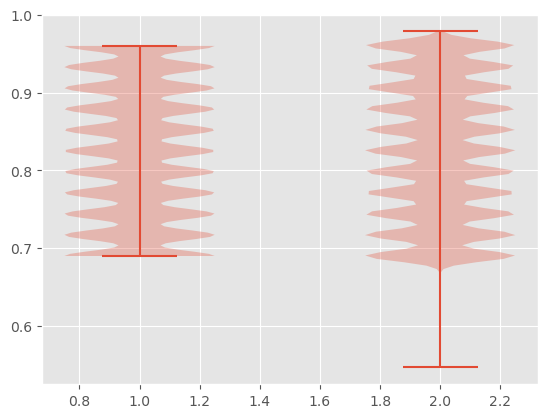

In [23]:
# visualize retrievability dist for option 1: constructing for equally spaced R
plt.violinplot([r_state_mesh_org.flatten(), r_state_mesh.flatten()], [1,2])

{'bodies': [<matplotlib.collections.PolyCollection at 0x12959d350>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x109d19390>,
 'cmins': <matplotlib.collections.LineCollection at 0x1295e46d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x1295e5610>}

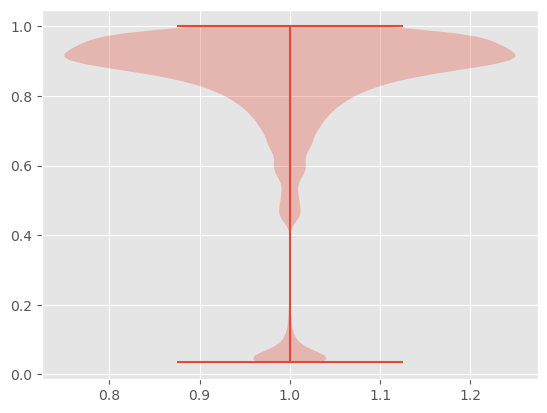

In [9]:
# visualize retrievability dist for option 2: equally spaced ivls
plt.violinplot(r_state_mesh[:, ::51].flatten())

In [24]:
i = 0
diff = 1e10
n_iter = 1000
n_iter = 10000

start = time.time()

# s_state = np.linspace(s_min, s_max, s_size)
# d_state = np.linspace(d_min, d_max, d_size)
# r_state = np.linspace(r_min, r_max, r_size)[::-1]

# s_state_mesh, d_state_mesh, r_state_mesh = np.meshgrid(s_state, d_state, r_state)

# ivl_mesh = next_interval(s_state_mesh, r_state_mesh)
# r_state_mesh = power_forgetting_curve(ivl_mesh, s_state_mesh)

while i < n_iter and diff > 1e-4 * s_size * d_size:
    next_stability_after_again = stability_after_failure(
        s_state_mesh, d_state_mesh, r_state_mesh
    )
    next_difficulty_after_again = next_difficulty(d_state_mesh, 1)
    next_cost_after_again = (
        i2c(next_stability_after_again, next_difficulty_after_again) + again_cost
    )

    next_stability_after_hard = stability_after_success(
        s_state_mesh, d_state_mesh, r_state_mesh, 2
    )
    next_difficulty_after_hard = next_difficulty(d_state_mesh, 2)
    next_cost_after_hard = (
        i2c(next_stability_after_hard, next_difficulty_after_hard) + hard_cost
    )

    next_stability_after_good = stability_after_success(
        s_state_mesh, d_state_mesh, r_state_mesh, 3
    )
    next_difficulty_after_good = next_difficulty(d_state_mesh, 3)
    next_cost_after_good = (
        i2c(next_stability_after_good, next_difficulty_after_good) + good_cost
    )

    next_stability_after_easy = stability_after_success(
        s_state_mesh, d_state_mesh, r_state_mesh, 4
    )
    next_difficulty_after_easy = next_difficulty(d_state_mesh, 4)
    next_cost_after_easy = (
        i2c(next_stability_after_easy, next_difficulty_after_easy) + easy_cost
    )

    expected_cost = (
        r_state_mesh
        * (
            review_rating_prob[0] * next_cost_after_hard
            + review_rating_prob[1] * next_cost_after_good
            + review_rating_prob[2] * next_cost_after_easy
        )
        + (1 - r_state_mesh) * next_cost_after_again
    )
    # update cost matrix
    optimal_cost = np.minimum(cost_matrix, expected_cost.min(axis=2))
    retention_matrix = None # Not valid anymore as we do not generate ivl from r_state: r_state[np.argmin(expected_cost, axis=2)] 
    
    diff = cost_matrix.sum() - optimal_cost.sum()
    cost_matrix = optimal_cost
    if i % 10 == 0:
        print(f"iteration {i:>5}, diff {diff:.2f}, time {time.time() - start:.2f}s")
    i += 1

end = time.time()
print(f"Time: {end - start:.2f}s")
init_stability = np.array(w[0:4])
init_difficulty = np.array([w[4] - (3 - g) * w[5] for g in range(1, 5)])
init_cost = cost_matrix[d2i(init_difficulty), s2i(init_stability)]
avg_cost = init_cost @ first_rating_prob
print(f"Average cost: {avg_cost:.2f}")

ii, jj = np.ogrid[:d_size, :s_size]
retention_matrix = r_state_mesh[ii,jj,np.argmin(expected_cost, axis=2)]
avg_retention = retention_matrix.mean()
print(f"Average retention: {avg_retention:.2f}")

iteration     0, diff 17210343.90, time 0.03s
iteration    10, diff 86294.14, time 0.29s
iteration    20, diff 45937.90, time 0.54s
iteration    30, diff 29175.40, time 0.79s
iteration    40, diff 19085.54, time 1.04s
iteration    50, diff 12550.36, time 1.30s
iteration    60, diff 8251.60, time 1.54s
iteration    70, diff 5427.43, time 1.81s
iteration    80, diff 3570.41, time 2.06s
iteration    90, diff 2349.06, time 2.30s
iteration   100, diff 1545.20, time 2.63s
iteration   110, diff 1016.24, time 2.98s
iteration   120, diff 668.37, time 3.25s
iteration   130, diff 439.62, time 3.61s
iteration   140, diff 289.16, time 3.87s
iteration   150, diff 190.21, time 4.14s
iteration   160, diff 125.11, time 4.44s
iteration   170, diff 82.29, time 4.79s
iteration   180, diff 54.13, time 5.12s
iteration   190, diff 35.60, time 5.51s
iteration   200, diff 23.42, time 5.88s
iteration   210, diff 15.40, time 6.18s
iteration   220, diff 10.13, time 6.48s
iteration   230, diff 6.66, time 6.81s
ite

## Visualization of the optimal policy

(31, 914)

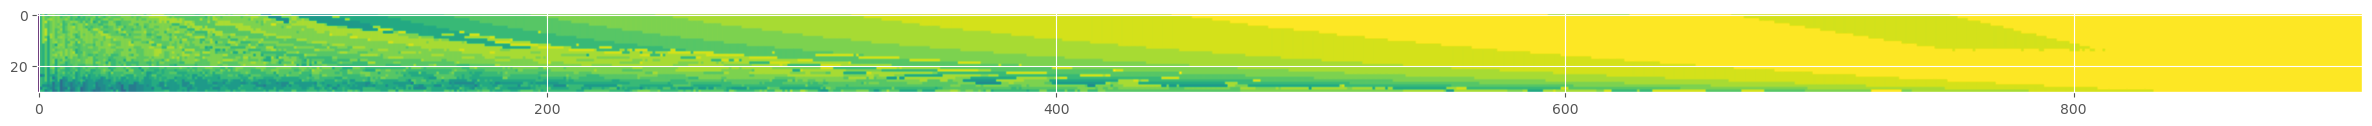

In [25]:
plt.figure(figsize=(30, 8))
plt.imshow(retention_matrix)
retention_matrix.shape

(31, 914)

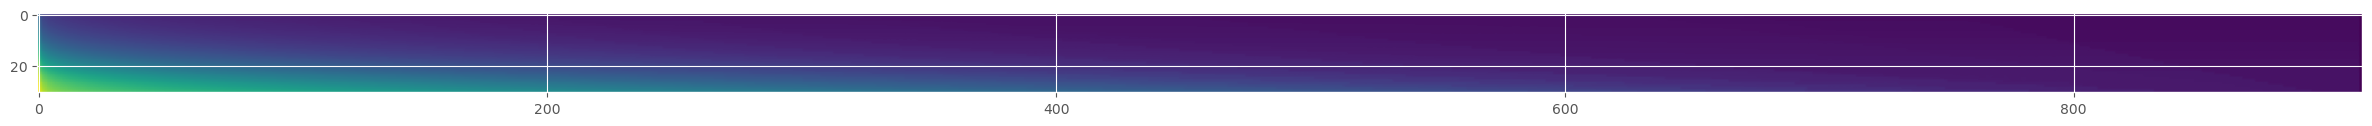

In [26]:
plt.figure(figsize=(30, 8))
plt.imshow(cost_matrix)
cost_matrix.shape

## What are the dimensions?

In [27]:
# difficulty, stability, retrievability

len(d_state), len(s_state), len(r_state)

(31, 914, 11)

In [28]:
expected_cost.shape

(31, 914, 11)

## Retrievability -> Lifetime cost

''

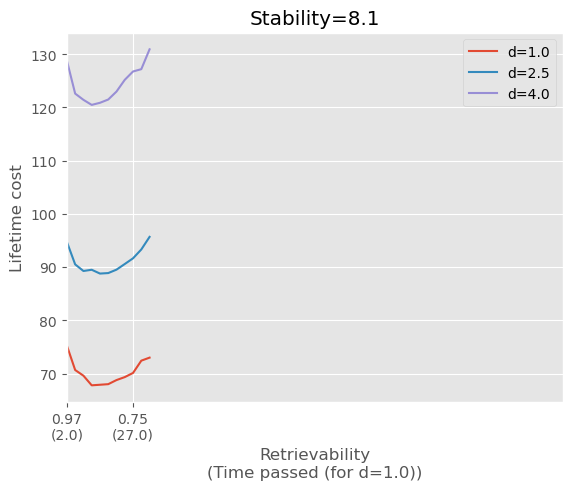

In [29]:
i_stability = 20
which_difficulty = 0

chosen_cost_matrix = expected_cost[:, i_stability, :] # choose a fixed time interval after which we review
# chosen_cost_matrix = cost_matrix # this corresponds to chooing the best next review time right now.

d_indices = [0,10,20,-1]
# d_indices = [5]
d_indices = [0,5,10]
d_labels = d_state[d_indices].round(1)
d_labels = [f'd={d:.1f}' for d in d_labels]

lifetime_cost = expected_cost[d_indices, i_stability, :].T
plt.plot(lifetime_cost, label=d_labels)
plt.legend()
plt.ylabel('Lifetime cost')
plt.title(f'Stability={s_state[i_stability]:.1f}')
plt.xlabel('Retrievability')

retrievability = r_state_mesh[d_indices[which_difficulty], i_stability].round(2)
ts = np.arange(len(retrievability))
if False: # print retrievability
    ts, retrievability = ts[::10], retrievability[::10]
    plt.xticks(ts, retrievability)
else: # print retrievability & time passed
    passed_time = ivl_mesh[d_indices[which_difficulty], i_stability]
    ls = [f'{r:.2f}\n({(t)})' for t, r in zip(passed_time, retrievability)]
    ts, ls = ts[::8], ls[::8]
    plt.xticks(ts, ls)
    plt.xlabel(f'Retrievability\n(Time passed (for {d_labels[which_difficulty]}))')

plt.xlim(0,60)
;

## Time passed -> Lifetime cost

In [161]:
def difference_in_lifetime_cost_at_passed_times(lifetime_cost, passed_time, at, filter=[1]):
    assert lifetime_cost.ndim == 1
    assert lifetime_cost.shape == passed_time.shape
    assert np.isclose(sum(filter), 1), f'filter {filter} should sum to 1 but sums to {sum(filter)}'
    
    # print(lifetime_cost, passed_time, at, filter)
    
    # copy to avoid modifying the original
    lifetime_cost, passed_time, at, filter = lifetime_cost.copy(), passed_time.copy(), at.copy(), filter.copy()
    
    diff = np.diff(passed_time)
    assert diff.any(), 'a time series with no time difference is not valid (and our flipping logic would not work).'
    if not (diff <= 0).all():
        # flip:
        passed_time = passed_time[::-1]
        filter = filter[::-1]
        lifetime_cost = lifetime_cost[::-1]
        
    assert (np.diff(passed_time) <= 0).all(), 'expect passed_time in non-increasing or non-decreasing order'
    msg = f'the filter should prefer values in the close future over the distant future (notice that we flipped based on passed_time).\n{filter} is not in increasing order. diff: {np.diff(filter)}'
    # assert (np.diff(filter) >= 0).all(), msg
    # print(msg)
    
    difference = []
    for time_passed in at:
        i_first_smaller = len(passed_time)-1
        for i, t in enumerate(passed_time):
            if i>0 and t < time_passed:
                i_first_smaller = i
                break
            
        # prev and future here indicate not the position in the array but the associated time - which goes backwards in the array.
        # thus future is before the past in the array
            
        past_score = lifetime_cost[i_first_smaller] # sum(filter_weight * lifetime_cost[filter_index] for filter_index, filter_weight in zip(filter_indices, filter))
        
        filter_indices = i_first_smaller + np.arange(-len(filter), 0)
        filter_indices = np.clip(filter_indices, 0, len(lifetime_cost)-1)
        future_score = sum(filter_weight * lifetime_cost[filter_index] for filter_index, filter_weight in zip(filter_indices, filter)) # lifetime_cost[i_first_smaller-1] 
        
        difference.append(future_score-past_score)
        
        # print(filter_indices, lifetime_cost[filter_indices], filter)
    return difference

[False  True  True  True  True  True  True  True  True  True]


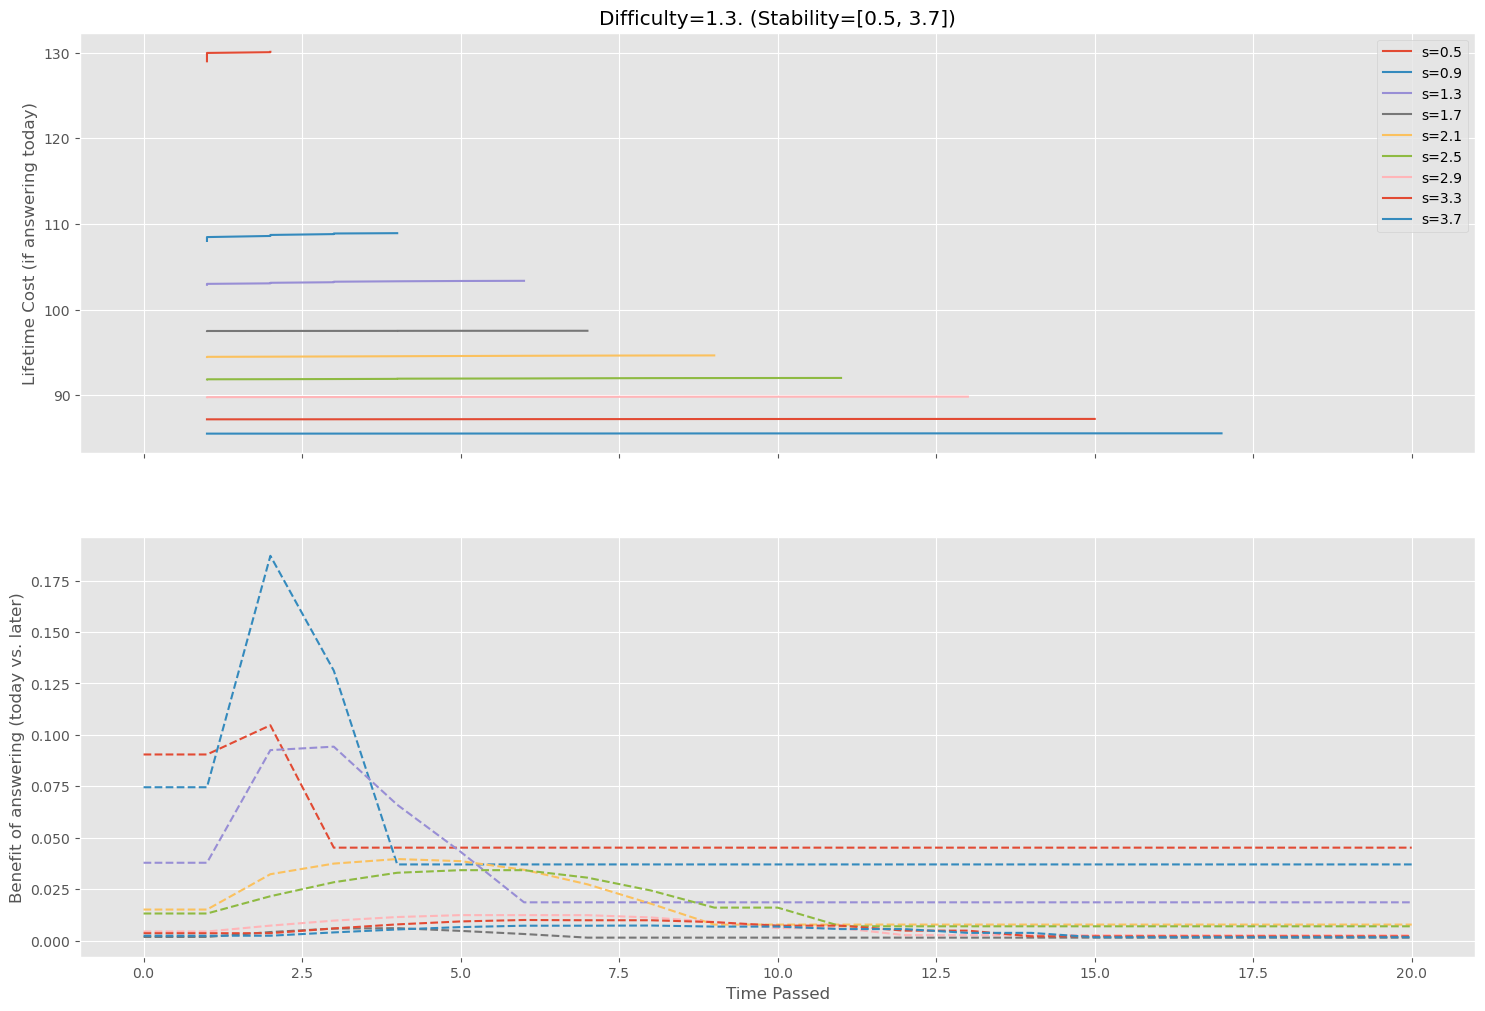

[ True  True  True  True  True  True  True  True  True]


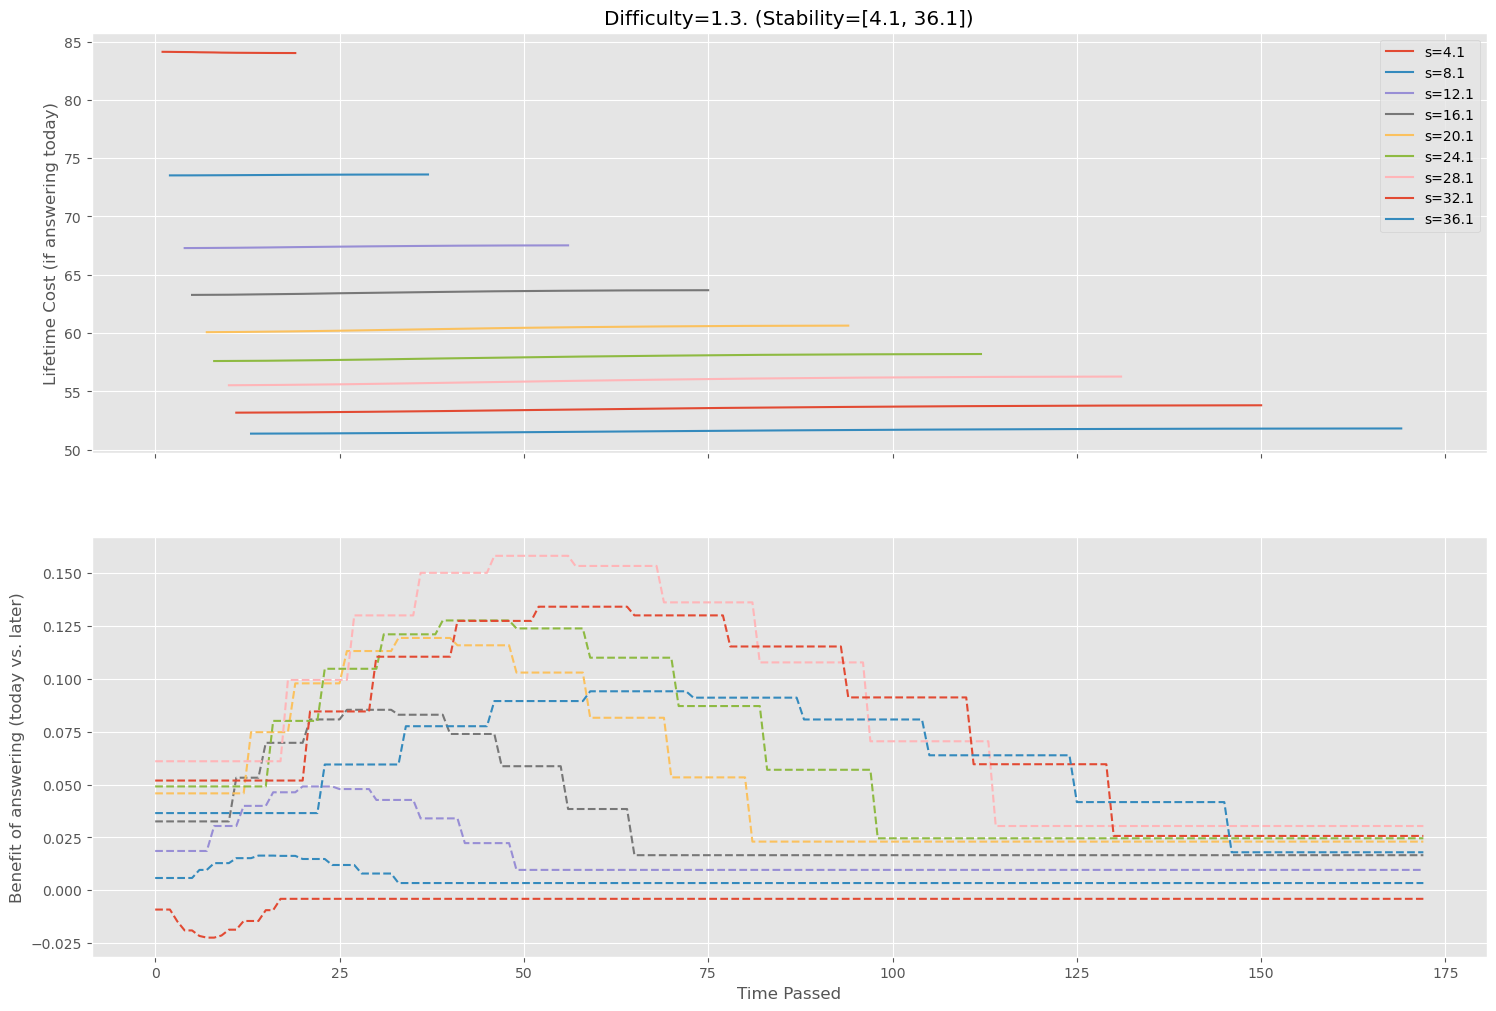

[ True  True  True  True  True  True  True  True  True  True]


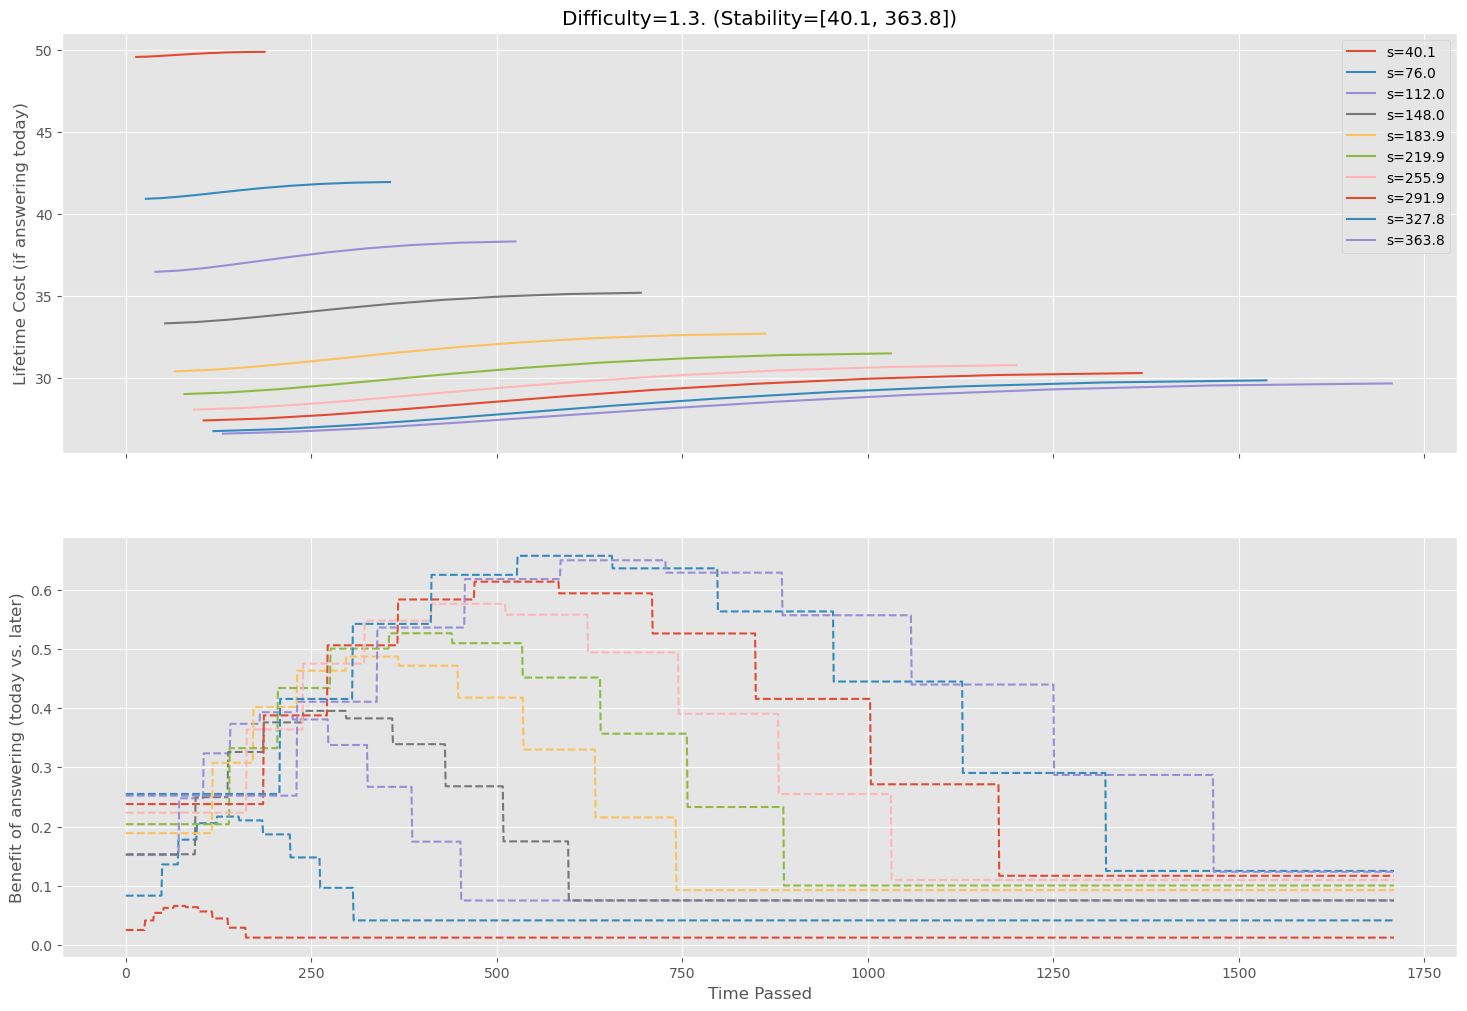

In [163]:
plot_differences = True
# differences_filter = [.1, .1, .1, .2, .2, .3]
differences_filter = [1]
differences_filter = [.1, .3, .6][::-1]

iss = [range(0,10,1), range(10,100,10), range(100, len(s_state), 90)]
# iss = [range(10,100,30)]
# iss = [[5]]
i_difficulty = 1

for is_stability in iss:
    lifetime_cost = expected_cost[i_difficulty, is_stability, :].T
    lifetime_cost = gaussian_filter(lifetime_cost, sigma=7, axes=0)
    passed_time = ivl_mesh[i_difficulty, is_stability].T
    stability = s_state[is_stability].round(1)
    
    # mask out those 'time series' that all have the same time
    mask = ~(passed_time == passed_time[:1, :]).all(axis=0)
    passed_time = passed_time[:, mask]
    lifetime_cost = lifetime_cost[:, mask]
    stability = stability[mask]
    
    print(mask)
    
    labels = [f's={s:.1f}' for s in stability]

    
    if not plot_differences:
        fig, ax1 = plt.subplots(1, 1, figsize=(18, 6))
    else:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True)
        
        passed_time_dense = list(range(np.floor(np.min(passed_time)).astype(int), np.floor(np.max(passed_time)).astype(int) + 4))
        passed_time_dense = list(range(0, np.floor(np.max(passed_time)).astype(int) + 4))
        difference = np.zeros((len(passed_time_dense), lifetime_cost.shape[1]))
        
        for i in range(lifetime_cost.shape[1]):
            difference[:, i] = difference_in_lifetime_cost_at_passed_times(lifetime_cost[:, i], passed_time[:, i], at=passed_time_dense, filter=differences_filter)
            
        # difference = difference >= 0
            
        # Plot on the second subplot with shared x-axis
        ax2.plot(passed_time_dense, difference, linestyle='--', label=labels)
        ax2.set_ylabel('Benefit of answering (today vs. later)')
        ax2.set_xlabel('Time Passed')

    # Plot on the first subplot
    ax1.plot(passed_time, lifetime_cost, label=labels)
    ax1.set_ylabel('Lifetime Cost (if answering today)')
    ax1.legend()
    ax1.set_title(f'Difficulty={d_state[i_difficulty]:.1f}. (Stability=[{stability.min()}, {stability.max()}])')

    plt.show()

''

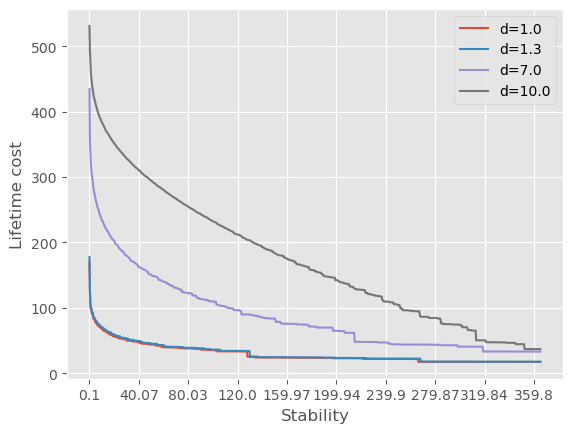

In [164]:
chosen_cost_matrix = cost_matrix # this corresponds to chooing the best next review time right now.
chosen_cost_matrix = expected_cost[:,:,-10] # choose a fixed time interval after which we review

d_indices = [0,1,20,-1]
d_labels = d_state[d_indices].round(1)
d_labels = [f'd={d:.1f}' for d in d_labels]
data = chosen_cost_matrix.T[:, d_indices]

plt.plot(data, label=d_labels)
plt.legend()
plt.ylabel('Lifetime cost')
plt.xlabel('Stability')
ts = range(len(s_state))
ls = s_state.round(2)
ts, ls = ts[::100], ls[::100]
plt.xticks(ts, ls)
;

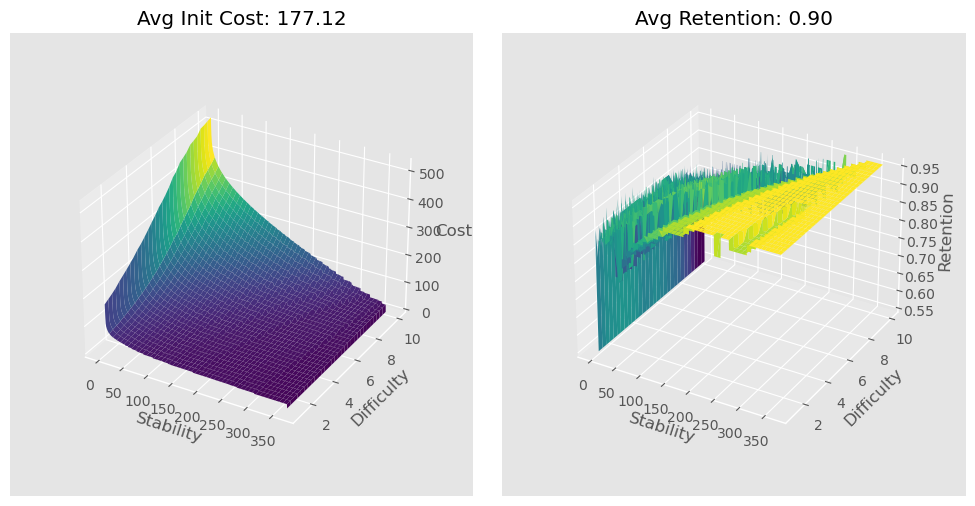

In [165]:
s_state_mesh_2d, d_state_mesh_2d = np.meshgrid(s_state, d_state)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(s_state_mesh_2d, d_state_mesh_2d, cost_matrix, cmap="viridis")
ax.set_xlabel("Stability")
ax.set_ylabel("Difficulty")
ax.set_zlabel("Cost")
ax.set_title(f"Avg Init Cost: {avg_cost:.2f}")
ax.set_box_aspect(None, zoom=0.8)
ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(s_state_mesh_2d, d_state_mesh_2d, retention_matrix, cmap="viridis")
ax.set_xlabel("Stability")
ax.set_ylabel("Difficulty")
ax.set_zlabel("Retention")
ax.set_title(f"Avg Retention: {avg_retention:.2f}")
ax.set_box_aspect(None, zoom=0.8)
plt.tight_layout()
plt.show()

Retention: 69.00%
Time: 1.01s, Iterations: 345


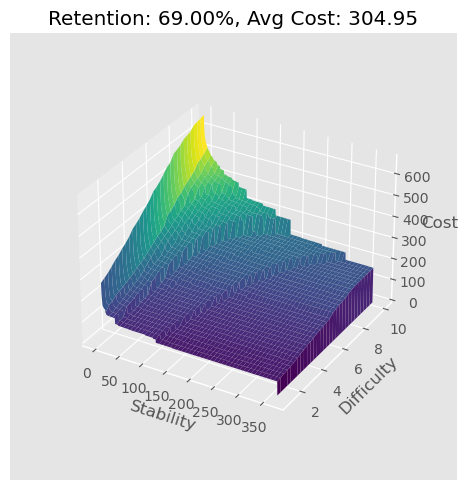

Retention: 72.00%
Time: 0.96s, Iterations: 335


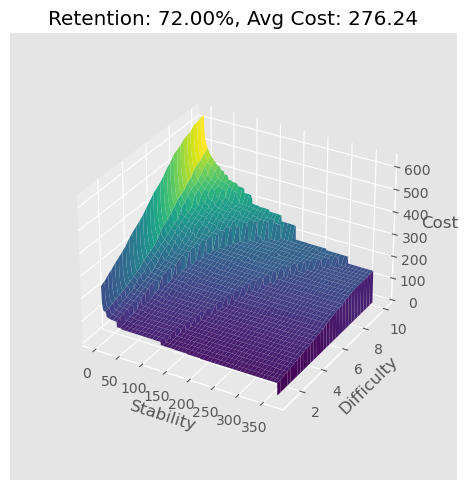

Retention: 75.00%
Time: 0.95s, Iterations: 328


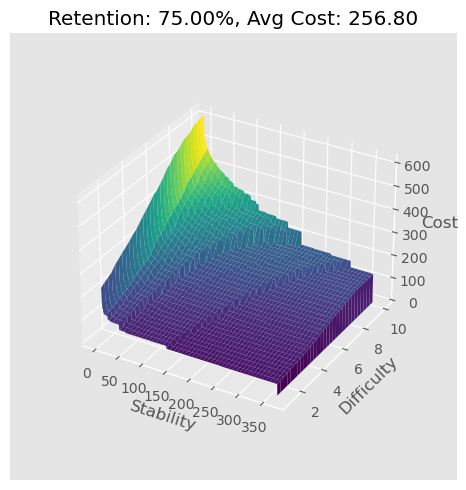

Retention: 78.00%
Time: 0.93s, Iterations: 333


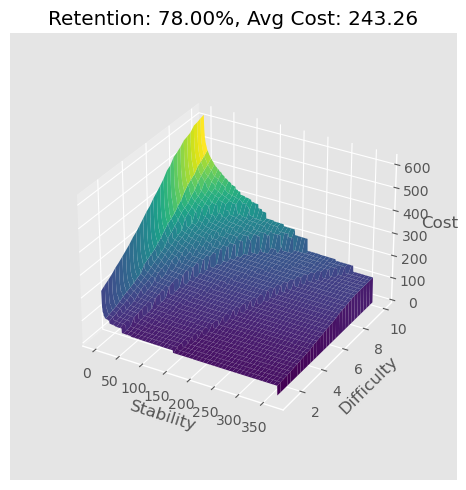

Retention: 81.00%
Time: 0.82s, Iterations: 329


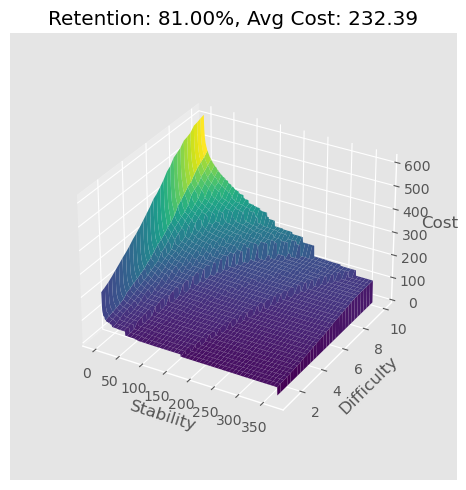

Retention: 84.00%
Time: 0.86s, Iterations: 340


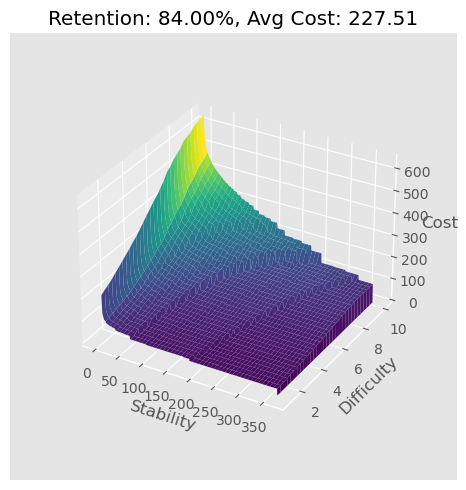

Retention: 87.00%
Time: 0.95s, Iterations: 354


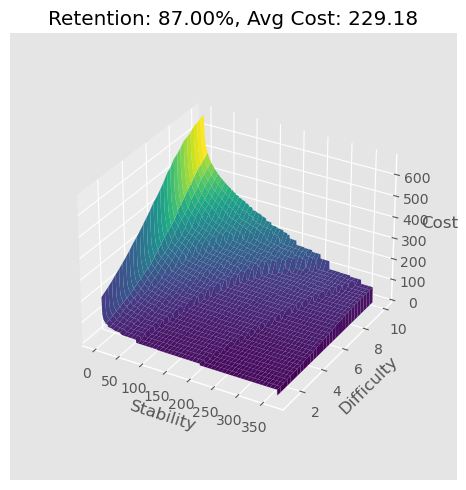

Retention: 90.00%
Time: 1.01s, Iterations: 383


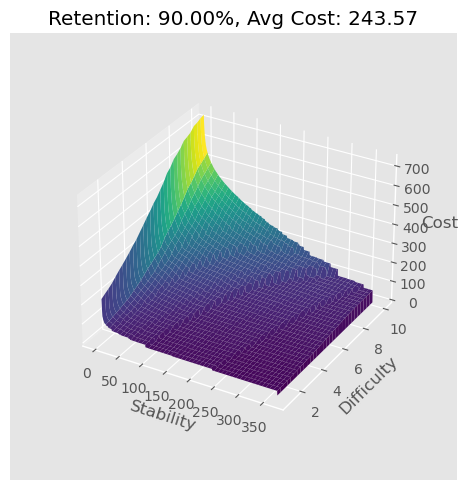

Retention: 93.00%
Time: 1.21s, Iterations: 427


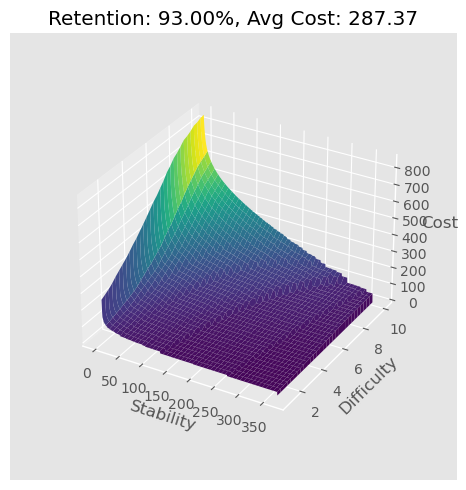

Retention: 96.00%
Time: 0.81s, Iterations: 290


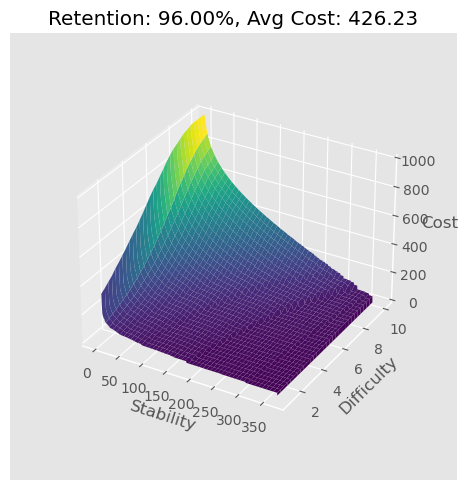

In [207]:
costs = []

r_range = np.linspace(r_min, r_max, 10)

for r in r_range:
    start = time.time()
    print(f"Retention: {r * 100:.2f}%")
    cost_matrix = np.zeros((d_size, s_size))
    cost_matrix.fill(1000)
    cost_matrix[:, -1] = 0
    s_state_mesh, d_state_mesh = np.meshgrid(s_state, d_state)
    r_state_mesh = r * np.ones((d_size, s_size))
    ivl_mesh = next_interval(s_state_mesh, r_state_mesh)
    r_state_mesh = power_forgetting_curve(ivl_mesh, s_state_mesh)

    i = 0
    diff = 10000
    n_iter = 1000
    while i < n_iter and diff > 1e-4 * s_size * d_size:
        next_stability_after_again = stability_after_failure(
            s_state_mesh, d_state_mesh, r_state_mesh
        )
        next_difficulty_after_again = next_difficulty(d_state_mesh, 1)
        next_cost_after_again = (
            i2c(next_stability_after_again,
                next_difficulty_after_again) + again_cost
        )

        next_stability_after_hard = stability_after_success(
            s_state_mesh, d_state_mesh, r_state_mesh, 2
        )
        next_difficulty_after_hard = next_difficulty(d_state_mesh, 2)
        next_cost_after_hard = (
            i2c(next_stability_after_hard, next_difficulty_after_hard) + hard_cost
        )

        next_stability_after_good = stability_after_success(
            s_state_mesh, d_state_mesh, r_state_mesh, 3
        )
        next_difficulty_after_good = next_difficulty(d_state_mesh, 3)
        next_cost_after_good = (
            i2c(next_stability_after_good, next_difficulty_after_good) + good_cost
        )

        next_stability_after_easy = stability_after_success(
            s_state_mesh, d_state_mesh, r_state_mesh, 4
        )
        next_difficulty_after_easy = next_difficulty(d_state_mesh, 4)
        next_cost_after_easy = (
            i2c(next_stability_after_easy, next_difficulty_after_easy) + easy_cost
        )

        expected_cost = (
            r_state_mesh
            * (
                review_rating_prob[0] * next_cost_after_hard
                + review_rating_prob[1] * next_cost_after_good
                + review_rating_prob[2] * next_cost_after_easy
            )
            + (1 - r_state_mesh) * next_cost_after_again
        )
        # update cost matrix
        optimal_cost = np.minimum(cost_matrix, expected_cost)
        diff = cost_matrix.sum() - optimal_cost.sum()
        cost_matrix = optimal_cost
        i += 1
    end = time.time()
    print(f"Time: {end - start:.2f}s, Iterations: {i}")
    init_stability = np.array(w[0:4])
    init_difficulty = np.array([w[4] - (3 - g) * w[5] for g in range(1, 5)])
    init_cost = cost_matrix[d2i(init_difficulty), s2i(init_stability)]
    avg_cost = init_cost @ first_rating_prob
    costs.append(avg_cost)
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(s_state_mesh, d_state_mesh, cost_matrix, cmap="viridis")
    ax.set_xlabel("Stability")
    ax.set_ylabel("Difficulty")
    ax.set_zlabel("Cost")
    ax.set_title(f"Retention: {r * 100:.2f}%, Avg Cost: {avg_cost:.2f}")
    ax.set_box_aspect(None, zoom=0.8)
    plt.tight_layout()
    plt.show()

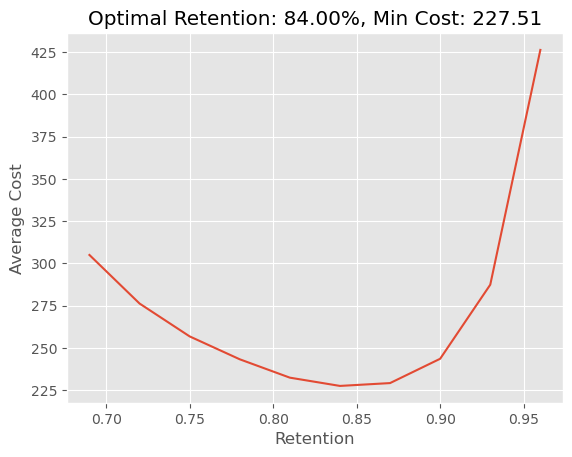

In [208]:
optimal_retention = r_range[np.argmin(costs)]
min_cost = np.min(costs)
plt.plot(r_range, costs)
plt.xlabel("Retention")
plt.ylabel("Average Cost")
plt.title(
    f"Optimal Retention: {optimal_retention * 100:.2f}%, Min Cost: {min_cost:.2f}"
)
plt.show()